<a href="https://colab.research.google.com/github/PratikHdhameliya/Projects/blob/project/Image_Classification_with_Deep_Learning_(CIFAR_10_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



*   Built and optimized Logistic Regression (LR), Multi-Layer Perceptron (MLP), and Convolutional Neural Network (CNN) models for image classification using the CIFAR-10 dataset.

*   Applied data augmentation (random horizontal flips) and L2 regularization to enhance model generalization.
*   Used PyTorch, Adam optimizer, and Cross-Entropy Loss for model training and optimization.


*   Evaluated models through confusion matrices and visualized loss curves, achieving best accuracy with the CNN model.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix
import seaborn as sns


torch.manual_seed(42) # Set manual seed

In [2]:
# DO NOT CHANGE
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)


Using device cuda:0


In [3]:
# Define the batch size for the data loaders
batch_size = 256

# Define the data augmentation(fliping half images of out dataset) and normalization transformations for the training set
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Apply random horizontal flip with a probability of 0.5
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize images with mean and std deviation of CIFAR-10 dataset
])

# Define the normalization transformation for the test set (no data augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensor format
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))  # Normalize images with mean and std deviation of CIFAR-10 dataset
])

In [4]:
# Load the data and transform the dataset

train_dataset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transforms)


100%|██████████| 170498071/170498071 [00:03<00:00, 46536132.05it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# You can verify the mean and standard deviation used in the normalization above by calculating the mean and std of the training dataset above.
mean_train = np.mean(train_dataset.data, axis=(0,1,2))/255
print('Mean1: ', mean_train[0])
print('Mean2: ', mean_train[1])
print('Mean3: ', mean_train[2])
mean_test = np.std(train_dataset.data, axis=(0,1,2))/255
print('Std1: ', mean_test[0])
print('Std2: ', mean_test[1])
print('Std3: ', mean_test[2])

Mean1:  0.49139967861519607
Mean2:  0.48215840839460783
Mean3:  0.44653091444546567
Std1:  0.24703223246328176
Std2:  0.24348512800005648
Std3:  0.26158784172796473


In [6]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Labels:  tensor([6, 0, 4, 1, 2, 7, 9, 4, 7, 8, 4, 5, 6, 0, 4, 2, 0, 1, 6, 1, 4, 3, 2, 3,
        2, 4, 0, 7, 5, 1, 8, 6, 3, 3, 7, 0, 4, 1, 7, 1, 3, 1, 1, 5, 6, 3, 7, 8,
        2, 3, 4, 8, 2, 1, 5, 6, 9, 9, 6, 9, 8, 3, 4, 7, 8, 7, 0, 2, 5, 2, 5, 8,
        6, 7, 4, 0, 5, 2, 0, 5, 1, 5, 5, 5, 1, 8, 6, 5, 7, 4, 9, 3, 2, 6, 6, 7,
        0, 1, 2, 3, 4, 6, 5, 9, 3, 5, 8, 8, 2, 6, 5, 0, 0, 2, 2, 0, 4, 4, 5, 2,
        8, 7, 4, 7, 2, 2, 0, 3, 9, 7, 9, 6, 6, 8, 4, 9, 4, 2, 6, 4, 3, 3, 6, 5,
        1, 1, 5, 0, 3, 0, 0, 7, 2, 3, 9, 3, 6, 8, 7, 9, 9, 1, 6, 2, 1, 4, 2, 9,
        5, 3, 0, 1, 8, 0, 7, 5, 5, 5, 7, 2, 3, 3, 5, 7, 2, 0, 3, 3, 3, 8, 5, 3,
        5, 8, 3, 7, 5, 7, 2, 3, 3, 3, 6, 1, 5, 9, 1, 6, 8, 7, 3, 0, 8, 0, 4, 8,
        1, 9, 3, 2, 8, 3, 7, 0, 8, 9, 2, 6, 8, 1, 8, 9, 2, 3, 0, 2, 1, 6, 3, 3,
        4, 4, 5, 3, 8, 9, 7, 6, 8, 6, 1, 8, 3, 9, 8, 6])


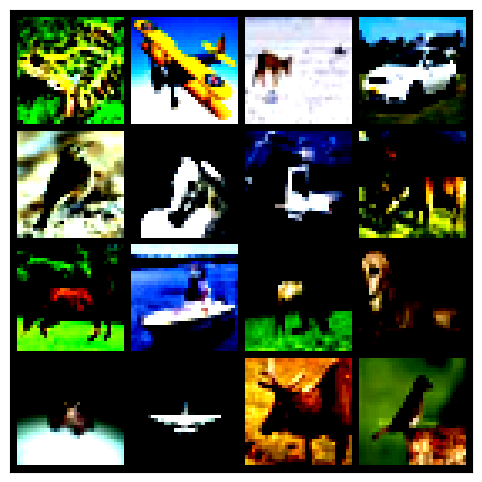

In [7]:
for images, labels in train_loader:
        print("Labels: ", labels)
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:16], nrow=4).permute(1, 2, 0))
        break

In [8]:
num_classes=10

In [9]:
def accuracy(correct,total):
    return correct/total

In [10]:
def train(dataloader,optimizer,model,loss_fn):
    model.train()

    loss_save=[]

    for data,target in dataloader:
        data,target=data.to(device),target.to(device)

        optimizer.zero_grad()
        output=model(data)

        loss=loss_fn(output,target)
        loss_save.append(loss.item())

        loss.backward()
        optimizer.step()
    return np.mean(loss_save)



def validate(dataloader, model,loss_fn):
    model.eval()

    loss_save=[]

    with torch.no_grad():
         for data,target in dataloader:
             data,target=data.to(device),target.to(device)

             output=model.forward(data)


             loss=loss_fn(output,target)
             loss_save.append(loss.item())
    return np.mean(loss_save)

from tqdm import trange

def runtraining (model, optimizer, loss_fn, device, num_epochs, train_loader, val_loader):
    train_loss_save=[]
    val_loss_save=[]

    for epoch in trange(num_epochs, desc='Epoch'):
        train_loss=train(train_loader,optimizer,model,loss_fn)
        val_loss=validate(val_loader, model,loss_fn)
        train_loss_save.append(train_loss)
        val_loss_save.append(val_loss)

        print(f'Training epoch{epoch+1}: ')
        print(f'Training Loss: {train_loss:.3f}')
        print(f'Validation Loss: {val_loss:.3f}')

    print('Training process has finished.')
    return train_loss_save, val_loss_save


In [11]:
class LR(torch.nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)


    def forward(self, x):
        flattened = torch.flatten(x, 1)
        outputs = torch.sigmoid(self.linear(flattened))
        return outputs

In [12]:
input_shape = train_loader.dataset.data.shape[1]*train_loader.dataset.data.shape[2]*train_loader.dataset.data.shape[3]
linear_regression = LR(input_shape, num_classes).to(device)
linear_regression.train()

LR(
  (linear): Linear(in_features=3072, out_features=10, bias=True)
)

In [13]:
optimizer = torch.optim.Adam(linear_regression.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [14]:
num_epochs = 20
train_loss, val_loss = runtraining (linear_regression, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epoch:   5%|▌         | 1/20 [00:31<09:52, 31.18s/it]

Training epoch1: 
Training Loss: 2.059
Validation Loss: 2.031


Epoch:  10%|█         | 2/20 [00:49<07:06, 23.67s/it]

Training epoch2: 
Training Loss: 2.024
Validation Loss: 2.020


Epoch:  15%|█▌        | 3/20 [01:06<05:52, 20.72s/it]

Training epoch3: 
Training Loss: 2.013
Validation Loss: 2.014


Epoch:  20%|██        | 4/20 [01:23<05:07, 19.21s/it]

Training epoch4: 
Training Loss: 2.005
Validation Loss: 2.011


Epoch:  25%|██▌       | 5/20 [01:44<04:57, 19.84s/it]

Training epoch5: 
Training Loss: 2.000
Validation Loss: 2.006


Epoch:  30%|███       | 6/20 [02:02<04:27, 19.08s/it]

Training epoch6: 
Training Loss: 1.995
Validation Loss: 2.003


Epoch:  35%|███▌      | 7/20 [02:19<04:02, 18.62s/it]

Training epoch7: 
Training Loss: 1.991
Validation Loss: 2.004


Epoch:  40%|████      | 8/20 [02:37<03:39, 18.28s/it]

Training epoch8: 
Training Loss: 1.988
Validation Loss: 2.000


Epoch:  45%|████▌     | 9/20 [02:54<03:15, 17.81s/it]

Training epoch9: 
Training Loss: 1.984
Validation Loss: 1.999


Epoch:  50%|█████     | 10/20 [03:11<02:55, 17.54s/it]

Training epoch10: 
Training Loss: 1.981
Validation Loss: 1.996


Epoch:  55%|█████▌    | 11/20 [03:28<02:36, 17.44s/it]

Training epoch11: 
Training Loss: 1.979
Validation Loss: 1.993


Epoch:  60%|██████    | 12/20 [03:45<02:19, 17.48s/it]

Training epoch12: 
Training Loss: 1.976
Validation Loss: 1.994


Epoch:  65%|██████▌   | 13/20 [04:02<02:00, 17.21s/it]

Training epoch13: 
Training Loss: 1.973
Validation Loss: 1.990


Epoch:  70%|███████   | 14/20 [04:18<01:41, 16.94s/it]

Training epoch14: 
Training Loss: 1.971
Validation Loss: 1.988


Epoch:  75%|███████▌  | 15/20 [04:35<01:24, 16.90s/it]

Training epoch15: 
Training Loss: 1.969
Validation Loss: 1.995


Epoch:  80%|████████  | 16/20 [04:52<01:07, 16.97s/it]

Training epoch16: 
Training Loss: 1.968
Validation Loss: 1.990


Epoch:  85%|████████▌ | 17/20 [05:09<00:50, 16.83s/it]

Training epoch17: 
Training Loss: 1.967
Validation Loss: 1.991


Epoch:  90%|█████████ | 18/20 [05:26<00:33, 16.81s/it]

Training epoch18: 
Training Loss: 1.966
Validation Loss: 1.986


Epoch:  95%|█████████▌| 19/20 [05:42<00:16, 16.79s/it]

Training epoch19: 
Training Loss: 1.964
Validation Loss: 1.986


Epoch: 100%|██████████| 20/20 [05:59<00:00, 17.96s/it]

Training epoch20: 
Training Loss: 1.961
Validation Loss: 1.985
Training process has finished.


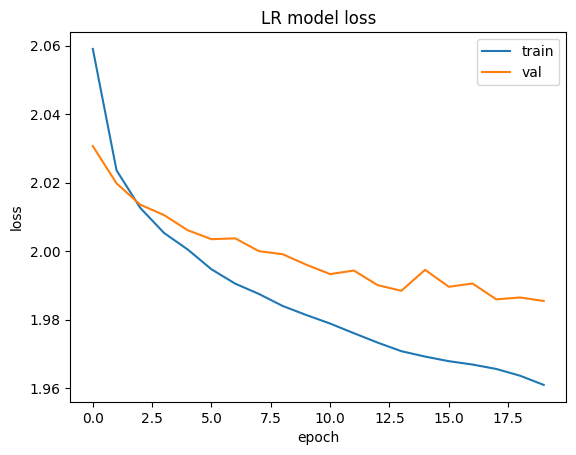

In [15]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('LR model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [16]:
class MLP(torch.nn.Module):
      def __init__(self, input_dim, output_dim):
          super(MLP, self).__init__()
          self.Layers=nn.Sequential(
              nn.Linear(input_dim,1650),
              nn.ReLU(),
              nn.Linear(1650,512),
              nn.ReLU(),
              nn.Linear(512,138),
              nn.ReLU(),
              nn.Linear(138,output_dim),

          )
      def forward(self,xb):
          xb=torch.flatten(xb,1)
          xb=self.Layers(xb)
          return xb

In [17]:
MLP=MLP(input_shape,num_classes).to(device)
MLP.train()

MLP(
  (Layers): Sequential(
    (0): Linear(in_features=3072, out_features=1650, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1650, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=138, bias=True)
    (5): ReLU()
    (6): Linear(in_features=138, out_features=10, bias=True)
  )
)

In [18]:
optimizer = torch.optim.Adam(MLP.parameters(), lr=0.001, weight_decay=0.0005)
loss_fn = torch.nn.CrossEntropyLoss()

In [19]:
num_epochs = 20
train_loss, val_loss = runtraining (MLP, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)


Epoch:   5%|▌         | 1/20 [00:17<05:41, 17.96s/it]

Training epoch1: 
Training Loss: 1.676
Validation Loss: 1.525


Epoch:  10%|█         | 2/20 [00:35<05:19, 17.77s/it]

Training epoch2: 
Training Loss: 1.500
Validation Loss: 1.480


Epoch:  15%|█▌        | 3/20 [00:52<04:54, 17.35s/it]

Training epoch3: 
Training Loss: 1.437
Validation Loss: 1.440


Epoch:  20%|██        | 4/20 [01:10<04:39, 17.46s/it]

Training epoch4: 
Training Loss: 1.386
Validation Loss: 1.409


Epoch:  25%|██▌       | 5/20 [01:26<04:18, 17.21s/it]

Training epoch5: 
Training Loss: 1.347
Validation Loss: 1.364


Epoch:  30%|███       | 6/20 [01:43<03:58, 17.04s/it]

Training epoch6: 
Training Loss: 1.312
Validation Loss: 1.360


Epoch:  35%|███▌      | 7/20 [02:01<03:43, 17.22s/it]

Training epoch7: 
Training Loss: 1.284
Validation Loss: 1.345


Epoch:  40%|████      | 8/20 [02:17<03:24, 17.04s/it]

Training epoch8: 
Training Loss: 1.253
Validation Loss: 1.316


Epoch:  45%|████▌     | 9/20 [02:34<03:06, 16.91s/it]

Training epoch9: 
Training Loss: 1.234
Validation Loss: 1.324


Epoch:  50%|█████     | 10/20 [02:52<02:51, 17.13s/it]

Training epoch10: 
Training Loss: 1.211
Validation Loss: 1.296


Epoch:  55%|█████▌    | 11/20 [03:08<02:32, 16.92s/it]

Training epoch11: 
Training Loss: 1.187
Validation Loss: 1.318


Epoch:  60%|██████    | 12/20 [03:25<02:14, 16.84s/it]

Training epoch12: 
Training Loss: 1.168
Validation Loss: 1.293


Epoch:  65%|██████▌   | 13/20 [03:42<01:59, 17.02s/it]

Training epoch13: 
Training Loss: 1.145
Validation Loss: 1.293


Epoch:  70%|███████   | 14/20 [03:59<01:41, 16.89s/it]

Training epoch14: 
Training Loss: 1.133
Validation Loss: 1.294


Epoch:  75%|███████▌  | 15/20 [04:16<01:24, 16.89s/it]

Training epoch15: 
Training Loss: 1.119
Validation Loss: 1.297


Epoch:  80%|████████  | 16/20 [04:33<01:08, 17.05s/it]

Training epoch16: 
Training Loss: 1.101
Validation Loss: 1.351


Epoch:  85%|████████▌ | 17/20 [04:50<00:50, 16.94s/it]

Training epoch17: 
Training Loss: 1.089
Validation Loss: 1.294


Epoch:  90%|█████████ | 18/20 [05:08<00:34, 17.45s/it]

Training epoch18: 
Training Loss: 1.070
Validation Loss: 1.279


Epoch:  95%|█████████▌| 19/20 [05:25<00:17, 17.24s/it]

Training epoch19: 
Training Loss: 1.065
Validation Loss: 1.263


Epoch: 100%|██████████| 20/20 [05:42<00:00, 17.12s/it]

Training epoch20: 
Training Loss: 1.045
Validation Loss: 1.294
Training process has finished.


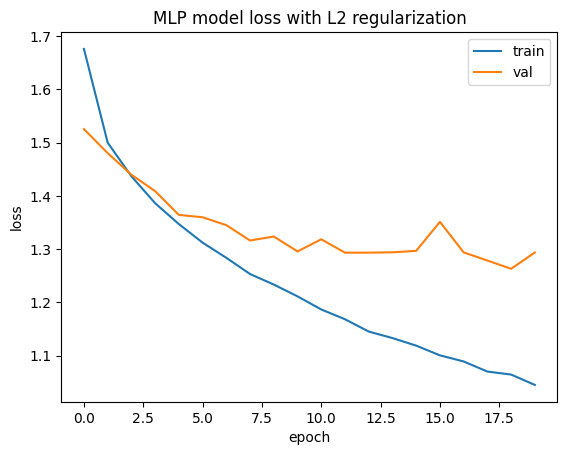

In [20]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('MLP model loss with L2 regularization')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [21]:
def predic_dl(model,data_loader):
    model.eval()
    y_pred=[]
    y_true=[]

    for i,(images,labels) in enumerate(data_loader):
        images=images.to(device)

        x=model(images)
        value,pred=torch.max(x,1)
        pred=pred.data.cpu()

        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

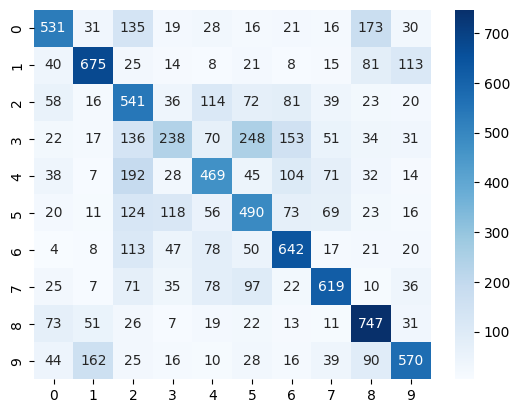

In [22]:
y_pred, y_true = predic_dl(MLP, test_loader)
conf_mat =confusion_matrix(y_true=y_true , y_pred=y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues')
plt.show()

In [23]:
class CNN(torch.nn.Module):
      def __init__(self, n_classes, in_channels=3):
          super(CNN, self).__init__()
          self.Layers=nn.Sequential(
              nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1),
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2),
              nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2),
              nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
              nn.ReLU(),
          )

          self.classifier=nn.Sequential(
              nn.Linear(in_features=120, out_features=84),
              nn.ReLU(),
              nn.Linear(in_features=84, out_features=n_classes),
          )

      def forward(self,xb):
          xb=self.Layers(xb)
          xb=torch.flatten(xb,1)
          xb=self.classifier(xb)
          return xb


In [24]:
CNN=CNN(num_classes,in_channels=3).to(device)
CNN.train()

CNN(
  (Layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [25]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNN.parameters(), lr = 0.001)

num_epochs=20
train_losses, val_losses = runtraining (CNN, optimizer, loss_fn, device, num_epochs, train_loader, test_loader)

Epoch:   5%|▌         | 1/20 [00:18<05:48, 18.37s/it]

Training epoch1: 
Training Loss: 1.828
Validation Loss: 1.571


Epoch:  10%|█         | 2/20 [00:36<05:28, 18.28s/it]

Training epoch2: 
Training Loss: 1.531
Validation Loss: 1.462


Epoch:  15%|█▌        | 3/20 [00:54<05:08, 18.16s/it]

Training epoch3: 
Training Loss: 1.431
Validation Loss: 1.376


Epoch:  20%|██        | 4/20 [01:12<04:46, 17.88s/it]

Training epoch4: 
Training Loss: 1.363
Validation Loss: 1.339


Epoch:  25%|██▌       | 5/20 [01:30<04:30, 18.04s/it]

Training epoch5: 
Training Loss: 1.308
Validation Loss: 1.287


Epoch:  30%|███       | 6/20 [01:48<04:10, 17.92s/it]

Training epoch6: 
Training Loss: 1.263
Validation Loss: 1.250


Epoch:  35%|███▌      | 7/20 [02:06<03:55, 18.15s/it]

Training epoch7: 
Training Loss: 1.223
Validation Loss: 1.222


Epoch:  40%|████      | 8/20 [02:24<03:35, 17.95s/it]

Training epoch8: 
Training Loss: 1.193
Validation Loss: 1.190


Epoch:  45%|████▌     | 9/20 [02:42<03:19, 18.13s/it]

Training epoch9: 
Training Loss: 1.163
Validation Loss: 1.173


Epoch:  50%|█████     | 10/20 [03:00<02:59, 18.00s/it]

Training epoch10: 
Training Loss: 1.133
Validation Loss: 1.147


Epoch:  55%|█████▌    | 11/20 [03:18<02:42, 18.03s/it]

Training epoch11: 
Training Loss: 1.111
Validation Loss: 1.134


Epoch:  60%|██████    | 12/20 [03:37<02:26, 18.27s/it]

Training epoch12: 
Training Loss: 1.084
Validation Loss: 1.154


Epoch:  65%|██████▌   | 13/20 [03:56<02:09, 18.46s/it]

Training epoch13: 
Training Loss: 1.061
Validation Loss: 1.092


Epoch:  70%|███████   | 14/20 [04:19<02:00, 20.05s/it]

Training epoch14: 
Training Loss: 1.041
Validation Loss: 1.079


Epoch:  75%|███████▌  | 15/20 [04:42<01:44, 20.82s/it]

Training epoch15: 
Training Loss: 1.019
Validation Loss: 1.058


Epoch:  80%|████████  | 16/20 [05:00<01:19, 19.92s/it]

Training epoch16: 
Training Loss: 1.003
Validation Loss: 1.072


Epoch:  85%|████████▌ | 17/20 [05:19<00:58, 19.56s/it]

Training epoch17: 
Training Loss: 0.986
Validation Loss: 1.045


Epoch:  90%|█████████ | 18/20 [05:36<00:38, 19.03s/it]

Training epoch18: 
Training Loss: 0.964
Validation Loss: 1.037


Epoch:  95%|█████████▌| 19/20 [05:58<00:19, 19.83s/it]

Training epoch19: 
Training Loss: 0.948
Validation Loss: 1.036


Epoch: 100%|██████████| 20/20 [06:25<00:00, 19.29s/it]

Training epoch20: 
Training Loss: 0.935
Validation Loss: 1.028
Training process has finished.


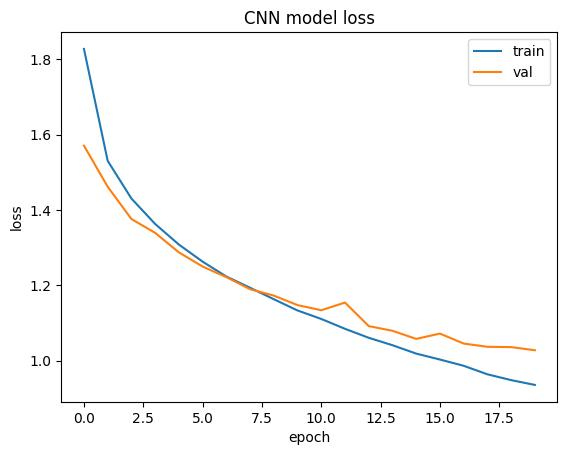

In [26]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [27]:
y_pred, y_true = predic_dl(CNN, test_loader)

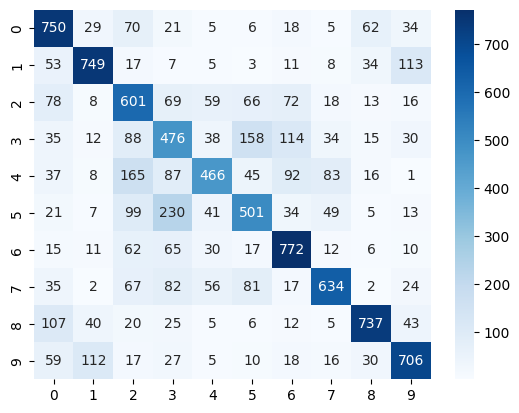

In [28]:
conf_mat =confusion_matrix(y_true=y_true , y_pred=y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues')
plt.show()